In [56]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# 데이터 불러오기
df = pd.read_csv('../data_prepared/dt_2.6/ByAstar_dt_2.6.csv')

df = df.dropna(subset=['combination'])

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(str(seq)) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')


In [57]:

# 모델 정의
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_input, phi_input])

# 시퀀스를 예측하기 위한 SimpleRNN 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = SimpleRNN(256, return_sequences=True, name='rnn_layer')(repeated_vector)

rnn_layer2 = SimpleRNN(256, return_sequences=True, name='rnn_layer2')(rnn_layer)

rnn_layer3 = SimpleRNN(512, return_sequences=True, name='rnn_layer3')(rnn_layer2)

rnn_layer4 = SimpleRNN(512, return_sequences=True, name='rnn_layer4')(rnn_layer3)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer4)

model = Model(inputs=[theta_input, phi_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([theta_train, phi_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_val, phi_val], np.expand_dims(sequence_val, -1)), epochs=200, batch_size=128)

# 검증
loss, accuracy = model.evaluate([theta_test, phi_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/200
87/87 [==============================] - 22s 201ms/step - loss: 1.0379 - accuracy: 0.5463 - val_loss: 0.8610 - val_accuracy: 0.5829
Epoch 2/200
87/87 [==============================] - 17s 191ms/step - loss: 0.7520 - accuracy: 0.6631 - val_loss: 0.4365 - val_accuracy: 0.8293
Epoch 3/200
87/87 [==============================] - 17s 193ms/step - loss: 0.4097 - accuracy: 0.8451 - val_loss: 0.3393 - val_accuracy: 0.8788
Epoch 4/200
87/87 [==============================] - 17s 196ms/step - loss: 0.3606 - accuracy: 0.8648 - val_loss: 0.3274 - val_accuracy: 0.8866
Epoch 5/200
87/87 [==============================] - 17s 201ms/step - loss: 0.3370 - accuracy: 0.8740 - val_loss: 0.3824 - val_accuracy: 0.8552
Epoch 6/200
87/87 [==============================] - 17s 200ms/step - loss: 0.3248 - accuracy: 0.8793 - val_loss: 0.3267 - val_accuracy: 0.8787
Epoch 7/200
87/87 [==============================] - 17s 192ms/step - loss: 0.3206 - accuracy: 0.8801 - val_loss: 0.3893 - val_accuracy:

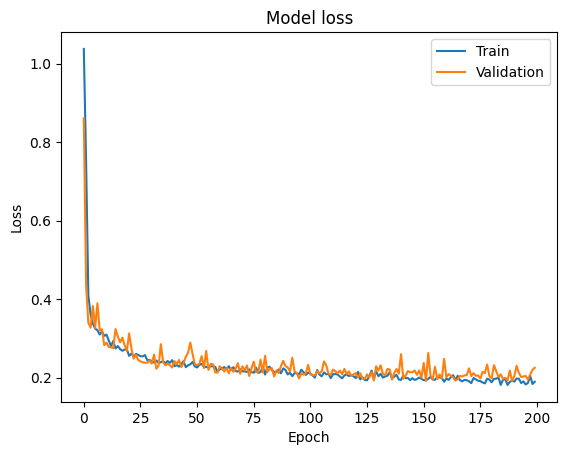

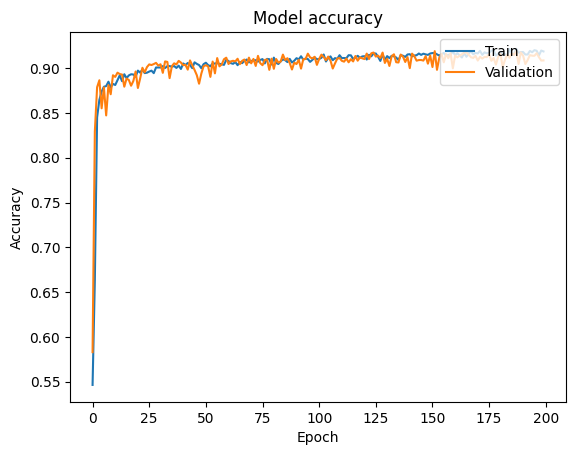

c:\Python310\lib\site-packages\keras\src\engine\functional.py:639: UserWarning: Input dict contained keys ['sequence_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


109/109 [==============================] - 3s 19ms/step - loss: 0.2198 - accuracy: 0.9089
Test Accuracy: 90.89
Test Loss: 21.98


In [58]:
def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_test, phi_test, sequence_test)

In [59]:
# 결과를 저장할 디렉토리 생성
models_dir = 'saved_test_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
# 모델 저장
model.save(os.path.join(models_dir, "SimpleRNN_test_model.h5"))

# # 모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model = load_model("SimpleRNN_model.h5")

c:\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
# # 가중치만 저장
# model.save_weights("model_weights.h5")

# # 구조만 저장
# model_json = model.to_json()
# with open("model_structure.json", "w") as json_file:
#     json_file.write(model_json)

# # 가중치 불러오기
# model.load_weights("model_weights.h5")

# # 구조만 불러오기
# from tensorflow.keras.models import model_from_json
# with open("model_structure.json", "r") as json_file:
#     model_json = json_file.read()
# loaded_model = model_from_json(model_json)

In [61]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples.ravel(),
    'Phi': phi_samples.ravel(),
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 저장할 디렉토리 생성
results_dir = 'samle_test_simpleRNN'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 결과를 CSV 파일로 저장
df_results.to_csv(os.path.join(results_dir, 'simpleRNN_results.csv'), index=False)

print("Results saved to simpleRNN_results.csv")


1/1 [==============================] - 0s 400ms/step
Results saved to simpleRNN_results.csv


In [62]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 39ms/step
Sample 1:
Theta    : [2.38197201]
Phi      : [2.77760905]
Actual   : [0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2]
Predicted: [0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2]
----------
Sample 2:
Theta    : [1.2735937]
Phi      : [1.22229083]
Actual   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 2 2 4 1 3 3 3 3 2 4 4 0 0 1]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 2 2 4 1 1 3 3 3 2 2 4 4 1 3]
----------
Sample 3:
Theta    : [2.09782845]
Phi      : [4.69740102]
Actual   : [0 0 0 0 0 0 0 0 0 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 2 0 4 0]
Predicted: [0 0 0 0 0 0 0 0 0 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 3 3 2]
----------
Sample 4:
Theta    : [2.56842684]
Phi      : [2.80172389]
Actual   : [0 0 0 0 0 0 0 0 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2]
Predicted: [0 0 0 0 0 0 0 0 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2]
----------
Sample 5: